In [3]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset



In [4]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [3]:
# data loader res 1_12
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res='1_12')

test_loader_1_12=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)


# data loader res 1_8
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res='1_8')

test_loader_1_8=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)



# data loader res 1_4
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res='1_4')

test_loader_1_4=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)



# data loader res 1_2
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res='1_2')

test_loader_1_2=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)



# data loader res 1
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res='1')

test_loader_1=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)


/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)


for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


In [3]:
# load trained models
model_1_12 = torch.load('/scratch/ab10313/pleiades/old_trained_models/trained_models/fcnn_k3_l3_select_1_12.pt')
model_1_8 = torch.load('/scratch/ab10313/pleiades/old_trained_models/trained_models/fcnn_k3_l3_select_1_8.pt')
model_1_4 = torch.load('/scratch/ab10313/pleiades/old_trained_models/trained_models/fcnn_k3_l3_select_1_4.pt')
model_1_2 = torch.load('/scratch/ab10313/pleiades/old_trained_models/trained_models/fcnn_k3_l3_select_1_2.pt')
model_1 = torch.load('/scratch/ab10313/pleiades/old_trained_models/trained_models/fcnn_k3_l3_select_1.pt')

In [6]:
# load trained models with different k
#model_1_12 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_1_12.pt')
model_1_8_k = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k9_l3_select_1_8.pt')
model_1_2_k = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_1_2_res_test.pt')
model_1_k = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k1_l3_select_1.pt')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_1_2_res_test.pt'

In [4]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [5]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [28]:
#label_list = ['Arabian Sea','Malvinas Current', 'New Zealand', 'North Pacific', 'Equatorial Atlantic',
#              'Gulf Stream', 'South Atlantic', 'Agulhas Current', 'South Pacific', 'Indian Ocean', 'Kuroshio Current','California Current' ]

#label_list = ['Arabian Sea','Malvinas Current', 'New Zealand', 'North Pacific', 'Equatorial Atlantic',
#              'Gulf Stream', 'South Atlantic', 'Agulhas Current', 'South Pacific', 'Indian Ocean', 'Kuroshio Current','California Current' ]


label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]

In [ ]:
# prediction and target of each model

# 1_12
for x_data, y_data in test_loader_1_12:
    prediction_1_12 = model_1_12(x_data.to(device)).detach().numpy() 
    target_1_12 = y_data.detach().numpy()


# 1_8 
for x_data, y_data in test_loader_1_8:
    prediction_1_8 = model_1_8(x_data.to(device)).detach().numpy() 
    target_1_8 = y_data.detach().numpy()

    
# 1_4 
for x_data, y_data in test_loader_1_4:
    prediction_1_4 = model_1_4(x_data.to(device)).detach().numpy() 
    target_1_4 = y_data.detach().numpy()

    
    
# 1_2
for x_data, y_data in test_loader_1_2:
    prediction_1_2 = model_1_2(x_data.to(device)).detach().numpy() 
    target_1_2 = y_data.detach().numpy()

    
    
# 1
for x_data, y_data in test_loader_1:
    prediction_1 = model_1(x_data.to(device)).detach().numpy() 
    target_1 = y_data.detach().numpy()



In [ ]:
# Physics based-paramerization
WB_FK08_param_1 = 0.07*np.load(BASE+'NN_data_1/'+'WB_FK08_param.npy')[submeso_dataset.test_ind]
WB_FK08_param_1_2 = 0.07*np.load(BASE+'NN_data_1_2/'+'WB_FK08_param.npy')[submeso_dataset.test_ind]
WB_FK08_param_1_4 = 0.07*np.load(BASE+'NN_data_1_4/'+'WB_FK08_param.npy')[submeso_dataset.test_ind]
WB_FK08_param_1_8 = 0.07*np.load(BASE+'NN_data_1_8/'+'WB_FK08_param.npy')[submeso_dataset.test_ind]
WB_FK08_param_1_12 = 0.07*np.load(BASE+'NN_data_1_12/'+'WB_FK08_param.npy')[submeso_dataset.test_ind]


In [ ]:
# prediction and target of each model with different k

# 1_12
#for x_data, y_data in test_loader_1_12:
#    prediction_1_12_k = model_1_12_k(x_data.to(device)).detach().numpy() 
#    target_1_12_k = y_data.detach().numpy()

# 1_8 
for x_data, y_data in test_loader_1_8:
    prediction_1_8_k = model_1_8_k(x_data.to(device)).detach().numpy() 
    target_1_8_k = y_data.detach().numpy()
    
    
# 1_2
for x_data, y_data in test_loader_1_2:
    prediction_1_2_k = model_1_2_k(x_data.to(device)).detach().numpy() 
    target_1_2_k = y_data.detach().numpy()
    
    
# 1
for x_data, y_data in test_loader_1:
    prediction_1_k = model_1_k(x_data.to(device)).detach().numpy() 
    target_1_k = y_data.detach().numpy()


# prediction and target by location

In [ ]:
# NOTE on MSE vs R^2
# because this the JFM data is subspamled and so is the location in dex, I assume a variance of 1 which is true for the full normalized datasets,
# Then the R^2 = 1- MSE rather than using the r2_score function which uses the variance of the subsetted data

baseline_mse_1_12 =  np.mean((target_1_12.flatten() - target_1_12.mean()) ** 2)
baseline_mse_1_8 =  np.mean((target_1_8.flatten() - target_1_8.mean()) ** 2)
baseline_mse_1_4 =  np.mean((target_1_4.flatten() - target_1_4.mean()) ** 2)
baseline_mse_1_2 =  np.mean((target_1_2.flatten() - target_1_2.mean()) ** 2)
baseline_mse_1 =  np.mean((target_1.flatten() - target_1.mean()) ** 2)

In [16]:
r2_1_12 = 1 - mean_squared_error(prediction_1_12.flatten(),target_1_12.flatten())/baseline_mse_1_12
corr_1_12,_ = pearsonr(prediction_1_12.flatten(),target_1_12.flatten())

r2_1_8 = 1 - mean_squared_error(prediction_1_8.flatten(),target_1_8.flatten())/baseline_mse_1_8
corr_1_8,_ = pearsonr(prediction_1_8.flatten(),target_1_8.flatten())

r2_1_4 = 1 - mean_squared_error(prediction_1_4.flatten(),target_1_4.flatten())/baseline_mse_1_4
corr_1_4,_ = pearsonr(prediction_1_4.flatten(),target_1_4.flatten())

r2_1_2 = 1 - mean_squared_error(prediction_1_2.flatten(),target_1_2.flatten())/baseline_mse_1_2
corr_1_2,_ = pearsonr(prediction_1_2.flatten(),target_1_2.flatten())

r2_1 = 1 - mean_squared_error(prediction_1.flatten(),target_1.flatten())/baseline_mse_1
corr_1,_ = pearsonr(prediction_1.flatten(),target_1.flatten())


KeyboardInterrupt



In [ ]:
#r2_1_12_k = 1 - mean_squared_error(prediction_1_12_k.flatten(),target_1_12_k.flatten())/baseline_mse_1_12
#corr_1_12_k,_ = pearsonr(prediction_1_12_k.flatten(),target_1_12_k.flatten())

r2_1_8_k = 1 - mean_squared_error(prediction_1_8_k.flatten(),target_1_8_k.flatten())/baseline_mse_1_8
corr_1_8_k,_ = pearsonr(prediction_1_8_k.flatten(),target_1_8_k.flatten())

r2_1_2_k = 1 - mean_squared_error(prediction_1_2_k.flatten(),target_1_2_k.flatten())/baseline_mse_1_2
corr_1_2_k,_ = pearsonr(prediction_1_2_k.flatten(),target_1_2_k.flatten())

r2_1_k = 1 - mean_squared_error(prediction_1_k.flatten(),target_1_k.flatten())/baseline_mse_1
corr_1_k,_ = pearsonr(prediction_1_k.flatten(),target_1_k.flatten())

In [ ]:
plt.ylabel(r'Correlation',fontsize=12)
plt.xlabel(r'$R^2$',fontsize=12)
plt.scatter(r2_1_12, corr_1_12,s=100,label='$1/12^o$')
plt.scatter(r2_1_8, corr_1_8,s=100,label='$1/8^o$')
plt.scatter(r2_1_4, corr_1_4,s=100,label='$1/4^o$')
plt.scatter(r2_1_2, corr_1_2,s=100,label='$1/2^o$')
plt.scatter(r2_1, corr_1,s=100,label='$1^o$')

#plt.scatter(r2_1_12_k, corr_1_12_k,s=100,label='$1/12^o k$')
#plt.scatter(r2_1_8_k, corr_1_8_k,s=100,label='$1/8^o k$')
#plt.scatter(r2_1_2_k, corr_1_2_k,s=100,label='$1/2^o k$')
#plt.scatter(r2_1_k, corr_1_k,s=100,label='$1^o k$')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k')
plt.legend(loc='lower right')
plt.ylim([.45,1])
plt.xlim([.45,1])

#plt.savefig('./figures/corr_r2_resolution')


In [ ]:
r2_1_12_loc = np.empty((12,1))
r2_1_12_loc[:] = np.nan
#corr_1_12_loc = np.empty((12,1))
#corr_1_12_loc[:] = np.nan

r2_1_8_loc = np.empty((12,1))
r2_1_8_loc[:] = np.nan
#corr_1_8_loc = np.empty((10,1))
#corr_1_8_loc[:] = np.nan

r2_1_4_loc = np.empty((12,1))
r2_1_4_loc[:] = np.nan
#corr_1_4_loc = np.empty((10,1))
#corr_1_4_loc[:] = np.nan

r2_1_2_loc = np.empty((12,1))
r2_1_2_loc[:] = np.nan
#corr_1_2_loc = np.empty((10,1))
#corr_1_2_loc[:] = np.nan

r2_1_loc = np.empty((12,1))
r2_1_loc[:] = np.nan
#corr_1_loc = np.empty((10,1))
#corr_1_loc[:] = np.nan


for i_loc in range(12):
    
    prediction_1_12_loc = prediction_1_12[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    target_1_12_loc = target_1_12[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    WB_param_1_12_loc = WB_FK08_param_1_12[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    
    #r2_1_12_loc_FK[i_loc] = 1- mean_squared_error(WB_param_1_12_loc.flatten(),target_1_12_loc.flatten())/baseline_mse_1_12    
    r2_1_12_loc[i_loc] = 1 - mean_squared_error(prediction_1_12_loc.flatten(),target_1_12_loc.flatten())/baseline_mse_1_12
    #corr_1_12_loc[i_loc],_ = pearsonr(prediction_1_12_loc.flatten(),target_1_12_loc.flatten())
    
    
    prediction_1_8_loc = prediction_1_8[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    target_1_8_loc = target_1_8[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    WB_param_1_8_loc = WB_FK08_param_1_8[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    
    #r2_1_8_loc_FK[i_loc] = 1- mean_squared_error(WB_param_1_8_loc.flatten(),target_1_8_loc.flatten())/baseline_mse_1_8 
    r2_1_8_loc[i_loc] = 1 - mean_squared_error(prediction_1_8_loc.flatten(),target_1_8_loc.flatten())/baseline_mse_1_8
    #corr_1_8_loc[i_loc],_ = pearsonr(prediction_1_8_loc.flatten(),target_1_8_loc.flatten())
    
    
    prediction_1_4_loc = prediction_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    target_1_4_loc = target_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    WB_param_1_4_loc = WB_FK08_param_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    
    #r2_1_4_loc_FK[i_loc] = 1- mean_squared_error(WB_param_1_4_loc.flatten(),target_1_4_loc.flatten())/baseline_mse_1_4 
    r2_1_4_loc[i_loc] = 1 - mean_squared_error(prediction_1_4_loc.flatten(),target_1_4_loc.flatten())/baseline_mse_1_4
    #corr_1_4_loc[i_loc],_ = pearsonr(prediction_1_4_loc.flatten(),target_1_4_loc.flatten())
     
    
    prediction_1_2_loc = prediction_1_2[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    target_1_2_loc = target_1_2[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    WB_param_1_2_loc = WB_FK08_param_1_2[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    
    #r2_1_2_loc_FK[i_loc] = 1- mean_squared_error(WB_param_1_2_loc.flatten(),target_1_2_loc.flatten())/baseline_mse_1_2 
    r2_1_2_loc[i_loc] = 1 - mean_squared_error(prediction_1_2_loc.flatten(),target_1_2_loc.flatten())/baseline_mse_1_2
    #corr_1_2_loc[i_loc],_ = pearsonr(prediction_1_2_loc.flatten(),target_1_2_loc.flatten())
    

    prediction_1_loc = prediction_1[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    target_1_loc = target_1[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    WB_param_1_loc = WB_FK08_param_1[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    
    #r2_1_loc_FK[i_loc] = 1- mean_squared_error(WB_param_1_loc.flatten(),target_1_loc.flatten())/baseline_mse_1 
    r2_1_loc[i_loc] = 1 - mean_squared_error(prediction_1_loc.flatten(),target_1_loc.flatten())/baseline_mse_1
    #corr_1_loc[i_loc],_ = pearsonr(prediction_1_loc.flatten(),target_1_loc.flatten())

NameError: name 'r2_1_12_loc' is not defined

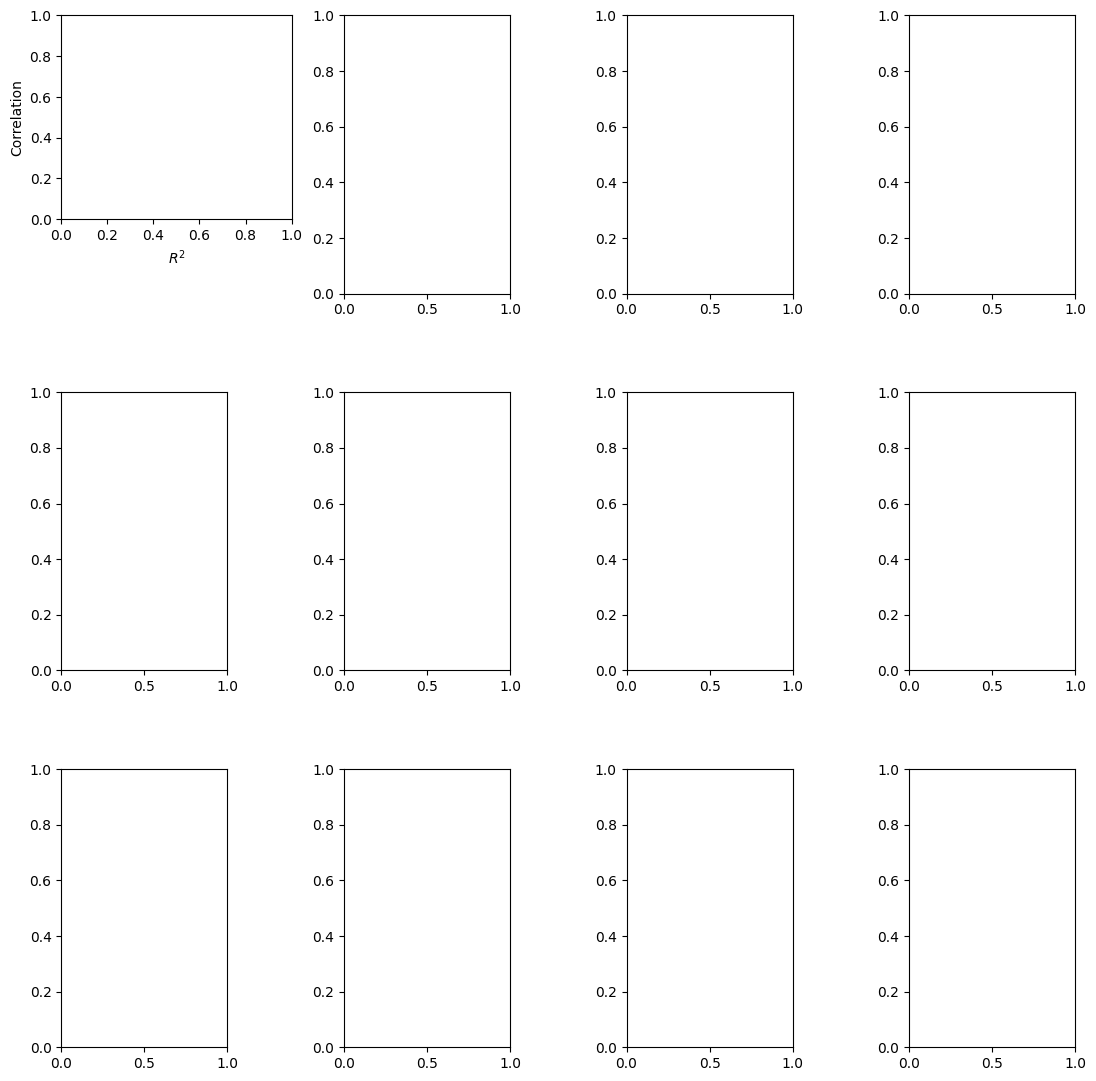

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(12,12))
fig.tight_layout(pad=5.0)

for i_loc in range(12):
    if i_loc<10:
        ax = plt.subplot(4,3,i_loc+1)
        #my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
        #plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
        if i_loc==0 or 3 or 6:
            plt.ylabel(r'Correlation')
            plt.xlabel(r'$R^2$')
        plt.scatter(r2_1_12_loc[i_loc], corr_1_12_loc[i_loc],s=100,label='$1/12^o$')
        plt.scatter(r2_1_8_loc[i_loc], corr_1_8_loc[i_loc],s=100,label='$1/8^o$')
        plt.scatter(r2_1_4_loc[i_loc], corr_1_4_loc[i_loc],s=100,label='$1/4^o$')
        plt.scatter(r2_1_2_loc[i_loc], corr_1_2_loc[i_loc],s=100,label='$1/2^o$')
        plt.scatter(r2_1_loc[i_loc], corr_1_loc[i_loc],s=100,label='$1^o$')
        plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k')
        plt.legend(loc='lower right', ncol=2)
        #plt.plot(np.roll(WB_cnn_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='CNN')
        #plt.plot(np.roll(WB_param_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='Param')
        
        plt.title(label_list[i_loc])
        #if i_loc==0:
        plt.ylim([0.3,1])
        plt.xlim([0.3,1])
        #plt.legend()
        #corr_loc[i_loc]
    else:
        ax = plt.subplot(4,3,i_loc+1)
        #my_xticks = ['Sep', 'Oct','Nov','Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov']
        #plt.xticks(np.arange(0,100,100/15), my_xticks,rotation = 45);               
        WB_sg_loc_mean_plot = np.nan
        WB_cnn_loc_mean_plot = np.nan
        WB_param_loc_mean_plot = np.nan

        #plt.ylabel(r'$\overline{wb}^z\ (W/m^2)$')
        plt.title(label_list[i_loc])
        #if i_loc==0:
        #plt.ylim([0,5e-9])
        plt.ylabel(r'Correlation')
        plt.xlabel(r'$R^2$')
        plt.ylim([0.3,1])
        plt.xlim([0.3,1])
        plt.legend()
        #clust_data = [[1,1],[1,1]]
        #collabel=("Corr", r"$R^2$")
    #ax.axis('tight')
    #ax.axis('off')
      #  the_table = ax.table(cellText=clust_data,loc='center')

        #corr_loc[i_loc]
        

plt.savefig('./figures/corr_r2_resolution_loc')


## Resolution R^2

In [25]:
res_strg = ['1_12','1_8','1_4','1_2','1']

r2_cnn_loc = np.empty((5,12))
r2_cnn_loc[:] = np.nan
r2_param_loc = np.empty((5,12))
r2_param_loc[:] = np.nan



for i_res in np.arange(1,5,1):
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res=res_strg[i_res])
    
    test_loader=DataLoader(
    submeso_dataset,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)
    
    test_ind = [submeso_dataset.test_ind]

    model = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_'+res_strg[i_res]+'.pt')
    WB_FK08_param = 0.07*np.load(BASE+'NN_data_'+res_strg[i_res]+'/WB_FK08_param.npy')[submeso_dataset.test_ind]     
    WB_sg_mean = np.load(BASE+'NN_data_'+res_strg[i_res]+'/WB_sg_mean.npy')[submeso_dataset.test_ind] 
    WB_sg_std = np.load(BASE+'NN_data_'+res_strg[i_res]+'/WB_sg_std.npy')[submeso_dataset.test_ind] 
    drF = np.load(BASE+'NN_data_'+res_strg[i_res]+'/drF.npy')[submeso_dataset.test_ind]
    
    for x_data, y_data in test_loader:
        prediction = model(x_data.to(device)).detach().numpy() 
        target = y_data.detach().numpy()
        

    WB_sg_mean_loc = np.empty((12))
    WB_sg_mean_loc[:] = np.nan
    WB_sg_std_loc = np.empty((12))
    WB_sg_std_loc[:] = np.nan

    mean_tile = np.transpose(np.tile(WB_sg_mean,(target.shape[3],target.shape[3],1,1)))
    std_tile = np.transpose(np.tile(WB_sg_std,(target.shape[3],target.shape[3],1,1)))

    # cell size 
    drF_loc = np.empty((12,2030,target.shape[3],target.shape[3]))
    drF_loc[:] = np.nan

    WB_cnn = np.squeeze(prediction*std_tile + mean_tile)
    WB_sg = np.squeeze(target*std_tile + mean_tile)

    WB_cnn_loc = np.empty((12,2030,target.shape[3],target.shape[3]))
    WB_cnn_loc[:] = np.nan
    WB_cnn_loc_mean = np.empty((12,2030))

    WB_sg_loc = np.empty((12,2030,target.shape[3],target.shape[3]))
    WB_sg_loc[:] = np.nan
    WB_sg_loc_mean = np.empty((12,2030))

    WB_param_loc = np.empty((12,2030,target.shape[3],target.shape[3]))
    WB_param_loc[:] = np.nan
    WB_param_loc_mean = np.empty((12,2030))
    WB_param_loc_mean[:] = np.nan


    location_month_index_test = location_month_index[test_ind]
    location_month_index_loc = np.empty((12,2030))
    location_month_index_loc[:] = np.nan
    
    WB_sg_loc_time_mean = np.empty((12,12))
    WB_param_loc_time_mean = np.empty((12,12))
    WB_cnn_loc_time_mean = np.empty((12,12))

    
    baseline_mse =  np.mean((WB_sg_loc_time_mean.flatten() - WB_sg_loc_time_mean.mean()) ** 2)

#    for i_loc in range(12):
#        prediction_loc = prediction[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
#        target_loc = target[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
#        WB_param_loc = WB_FK08_param[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]

#        r2_param_loc[i_res,i_loc] = 1- mean_squared_error(WB_param_loc.flatten(),target_loc.flatten())/baseline_mse    
#        r2_cnn_loc[i_res,i_loc] = 1 - mean_squared_error(prediction_loc.flatten(),target_loc.flatten())/baseline_mse
  

    for i_loc in range(12):
        WB_sg_mean_loc[i_loc] = np.nanmean(WB_sg_std[location_index[test_ind]==i_loc])
        WB_sg_std_loc[i_loc] = np.nanmean(WB_sg_std[location_index[test_ind]==i_loc])

        drF_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF[location_index[test_ind]==i_loc]

        WB_param_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_FK08_param[location_index[test_ind]==i_loc]
        WB_param_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_param_loc[i_loc]*WB_param_loc[i_loc]*drF[i_loc], [1,2])) / np.nansum(drF[i_loc]))**0.5

        WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
        WB_cnn_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF[i_loc], [1,2])) / np.nansum(drF[i_loc]))**0.5  #np.nanmean(np.nanmean(WB_cnn_loc[i_loc],1),1)

        WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
        WB_sg_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF[i_loc], [1,2]))/ np.nansum(drF[i_loc]))**0.5 #np.nanmean(np.nanmean(WB_sg_loc[i_loc],1),1)

        location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]
        WB_sg_loc_mean_sorted = WB_sg_loc_mean#[lat_ind_sorted,:]
        WB_param_loc_mean_sorted = WB_param_loc_mean#[lat_ind_sorted,:]
        WB_cnn_loc_mean_sorted = WB_cnn_loc_mean#[lat_ind_sorted,:]

        for i_month in range(12):
            WB_sg_loc_time_mean[i_loc,i_month] = np.mean(WB_sg_loc_mean_sorted[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
            WB_param_loc_time_mean[i_loc,i_month] = np.mean(WB_param_loc_mean_sorted[i_loc,~np.isnan(WB_param_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
            WB_cnn_loc_time_mean[i_loc,i_month] = np.mean(WB_cnn_loc_mean_sorted[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])

        baseline_mse =  np.mean((WB_sg.flatten() - WB_sg.mean()) ** 2)
        r2_cnn_loc[i_res,i_loc] = 1 - mean_squared_error(WB_sg_loc_time_mean[i_loc],WB_cnn_loc_time_mean[i_loc])/baseline_mse

    



/state/partition1/job-39017078/ipykernel_3036797/19831088.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  location_month_index_test = location_month_index[test_ind]
/state/partition1/job-39017078/ipykernel_3036797/19831088.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  WB_sg_mean_loc[i_loc] = np.nanmean(WB_sg_std[location_index[test_ind]==i_loc])
/state/partition1/job-39017078/ipykernel_3036797/19831088.py:83: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of

In [10]:
target.shape[3]

80

In [20]:
r2_cnn_loc

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [0.98334119, 0.98631945, 0.98870308, 0.77811995, 0.98888334,
        0.99382871, 0.97486518, 0.98873296, 0.94820256, 0.83193949,
        0.99523166, 0.93197493],
       [0.99020444, 0.99495627, 0.99611631, 0.79814342, 0.99657906,
        0.99625513, 0.99643492, 0.99666849, 0.98090688, 0.91058069,
        0.99788389, 0.98222079],
       [0.99666756, 0.99882078, 0.99883805, 0.62238702, 0.99956475,
        0.99932894, 0.99935861, 0.99955851, 0.99912537, 0.93578925,
        0.99039902, 0.99623921],
       [0.99828424, 0.99977341, 0.99975644, 0.46230564, 0.99960514,
        0.99955237, 0.99938316, 0.99973436, 0.99965407, 0.95056722,
        0.9808352 , 0.99673381]])

In [ ]:
# monthly averages 

WB_sg_loc_time_mean = np.empty((12,12))
WB_param_loc_time_mean = np.empty((12,12))
WB_cnn_loc_time_mean = np.empty((12,12))
WB_param_Lf_BD_loc_time_mean = np.empty((12,12))
WB_param_Lf_FK_loc_time_mean = np.empty((12,12))

for i_loc in range(12):
    for i_month in range(12):
        WB_sg_loc_time_mean[i_loc,i_month] = np.mean(WB_sg_loc_mean_sorted[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_param_loc_time_mean[i_loc,i_month] = np.mean(WB_param_loc_mean_sorted[i_loc,~np.isnan(WB_param_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_cnn_loc_time_mean[i_loc,i_month] = np.mean(WB_cnn_loc_mean_sorted[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        #WB_param_Lf_BD_loc_time_mean[i_loc,i_month] = np.mean(WB_param_Lf_BD_loc_mean[i_loc,~np.isnan(WB_param_Lf_BD_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        #WB_param_Lf_FK_loc_time_mean[i_loc,i_month] = np.mean(WB_param_Lf_FK_loc_mean[i_loc,~np.isnan(WB_param_Lf_FK_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        

In [21]:
r2_param_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_param_loc.npy')
r2_cnn_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_loc.npy')

In [ ]:
res_strg = ['1_12','1_8','1_4','1_2','1']
midpoints = [60,40,20,10,5]
r_max = np.sqrt(8**2+8**2)
jacob_ftr_frac_r_res = np.empty((5,10,round(r_max)+1))

for i_res in range(5):
    
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res=res_strg[i_res])

    test_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)

    model = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_'+res_strg[i_res]+'.pt')

    
    for x_data, y_data in test_loader:
        x_input= x_data
        x_input.requires_grad = True
        y_output = model(x_input.to(device))

In [29]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0

for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]


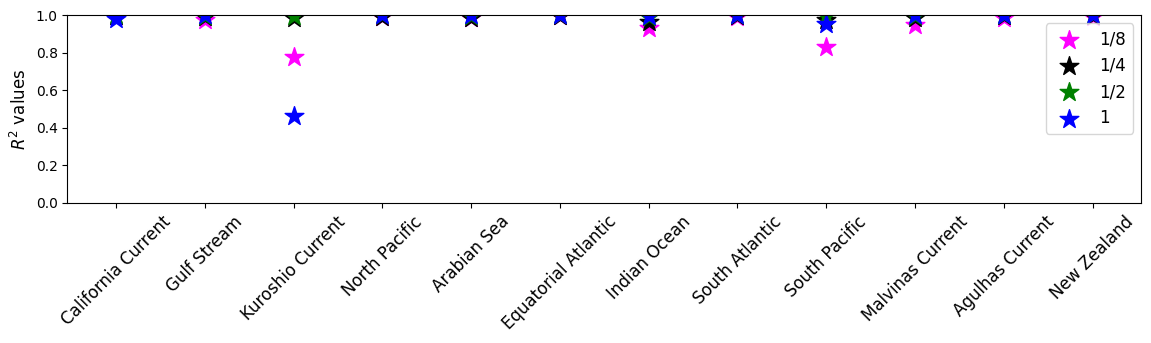

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,3))
fig.tight_layout(pad=3.0)

#plt.scatter(range(12),r2_cnn_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='*',label='1/12')
#plt.scatter(range(12),r2_cnn_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='*',label='1/12')
plt.scatter(range(12),r2_cnn_loc[1,lat_ind_sorted],s=200,c='magenta',marker='*',label='1/8')
plt.scatter(range(12),r2_cnn_loc[2,lat_ind_sorted],s=200,c='k',marker='*',label='1/4')
plt.scatter(range(12),r2_cnn_loc[3,lat_ind_sorted],s=200,c='green',marker='*',label='1/2')
plt.scatter(range(12),r2_cnn_loc[4,lat_ind_sorted],s=200,c='blue',marker='*',label='1')
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list)), my_xticks,rotation = 45,fontsize=12);
#plt.xticks(np.arange(len(label_list)), label_list,rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12)

#plt.savefig('./figures/r2_resolution_location_lat_sorted', transparent=True)



# feature importance by resolution

In [3]:
def Jacobian_halo(x,y):
    if y.shape[1] != 1:
        print('wrong shape')
  
    dydx = torch.zeros(x.shape[1])

    grad = torch.autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y),
        allow_unused=True, retain_graph=True, create_graph=True)[0]

    if grad.shape != x.shape:
        print('Error in dimensions')

    return grad.nanmean(dim=0)



In [4]:
res_strg = ['1_12','1_8','1_4','1_2','1']
midpoints = [60,40,20,10,5]
r_max = np.sqrt(8**2+8**2)
jacob_ftr_frac_r_res = np.empty((5,10,round(r_max)+1))

for i_res in range(5):
    
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res=res_strg[i_res])

    test_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)

    model = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k3_l3_select_'+res_strg[i_res]+'.pt')

    
    for x_data, y_data in test_loader:
        x_input= x_data
        x_input.requires_grad = True
        y_output = model(x_input.to(device))
    
    jacobian_halo = Jacobian_halo(x_input,y_output[:,:,midpoints[i_res],midpoints[i_res]])
    mid = midpoints[i_res]
    
    jacob_ftr_frac_r = np.empty((10,round(r_max)+1))

    for i_ftr in range(10):
        jacob_ftr = jacobian_halo.detach().numpy()[i_ftr]
        jacob_ftr_sum_r = np.empty((round(r_max)+1,1))
        for ir in range(round(r_max)+1):
            jacob_ftr_sum = 0
            for i in range(mid*2):
                for j in range(mid*2):
                    if (i-mid)**2+(j-mid)**2 <= (ir)**2:
                        jacob_ftr_sum  = jacob_ftr_sum + np.abs(jacob_ftr[i,j])
            jacob_ftr_sum_r[ir]= jacob_ftr_sum
        jacob_ftr_frac_r[i_ftr,:] = np.squeeze(jacob_ftr_sum_r[:])/jacob_ftr_sum_r[-1]
    jacob_ftr_frac_r_res[i_res,:,:] = jacob_ftr_frac_r[:,:]

/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
np.save(save_path+'/jacob_ftr_frac_r_res.py',jacob_ftr_frac_r_res)

In [ ]:
jacob_ftr_frac_r_res_ld = np.load(save_path+'/jacob_ftr_frac_r_res.py')

In [ ]:
input_features_for_plot = [r'$\overline{\nabla b}^z$', '$f$','$N^2$','$H_{ML}$',r'$\tau$', '$Q^*$','$H_{BL}$',
                 '$\overline{\delta}^z$', '$\overline{\zeta}^z$', '$\overline{\sigma}^z$' ]

In [ ]:
fig, main_ax = plt.subplots(nrows=2, ncols=3,figsize=(12,8))
fig.tight_layout(pad=5)

for i_res in range(5):
    ax = plt.subplot(2,3,i_res+1)
    for i_ftr in range(10):
        plt.plot(jacob_ftr_frac_r_res[i_res,i_ftr,:],range(round(r_max)+1),label=input_features_for_plot[i_ftr])
        plt.legend(ncol=2)

    plt.plot(np.mean(jacob_ftr_frac_r_res[i_res,:,:],0),range(round(r_max)+1),'k')
    plt.legend(ncol=2)
    plt.xlim([0,1])
    plt.ylim([0,11])
    plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)
    plt.xlabel('fraction of Jacobian')
    plt.ylabel('Grid points away from ouptut')
    plt.title('res '+res_strg[i_res])
plt.savefig('./figures/jacobian_feature_importance_halo_grid_resolution_panels')

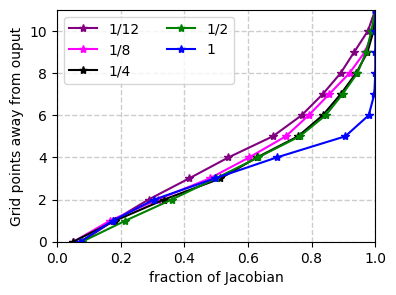

In [10]:
fig, main_ax = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
fig.tight_layout(pad=5)

plt.plot(np.mean(jacob_ftr_frac_r_res[3,:,:],0),range(round(r_max)+1),c= 'purple',marker='*',label='1/12')
plt.plot(np.mean(jacob_ftr_frac_r_res[0,:,:],0),range(round(r_max)+1),c= 'magenta',marker='*',label='1/8')
plt.plot(np.mean(jacob_ftr_frac_r_res[1,:,:],0),range(round(r_max)+1),c= 'k',marker='*',label='1/4')
plt.plot(np.mean(jacob_ftr_frac_r_res[2,:,:],0),range(round(r_max)+1),c= 'green',marker='*',label='1/2')
plt.plot(np.mean(jacob_ftr_frac_r_res[4,:,:],0),range(round(r_max)+1),c= 'blue',marker='*',label='1')
plt.legend(ncol=2)
plt.xlim([0,1])
plt.ylim([0,11])
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)
plt.xlabel('fraction of Jacobian')
plt.ylabel('Grid points away from ouput')
plt.savefig('./figures/jacobian_halo_grid_resolution_combined')